<a href="https://colab.research.google.com/github/potapov-dm/image-classification-cat-dog/blob/main/image_classification_cat_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cat vs. Dog Image Classification

Building from scratch a classifier model capable of distinguishing dogs from cats.  

1.   Explore the data
2.   Building a convnet
3.   Data preprocessing
4.   Training
5.   Visualize the transformation of the input signal that passes through convnet
6.   Evaluating accuracy and loss for the model
7.   Conclusion 1
8.   Feature extraction
9.   Fine-tuning
10.  Conclusion 2

## Explore the data

Downloading and unzipping data

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2023-10-02 09:38:49--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.114.207, 172.217.214.207, 108.177.111.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.114.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   165MB/s    in 0.4s    

2023-10-02 09:38:50 (165 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Data path constants

In [3]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Names of image files in the training set

In [4]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.588.jpg', 'cat.220.jpg', 'cat.372.jpg', 'cat.318.jpg', 'cat.162.jpg', 'cat.592.jpg', 'cat.775.jpg', 'cat.926.jpg', 'cat.128.jpg', 'cat.657.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


Number of instances in datasets

In [5]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


Examples of images in datasets

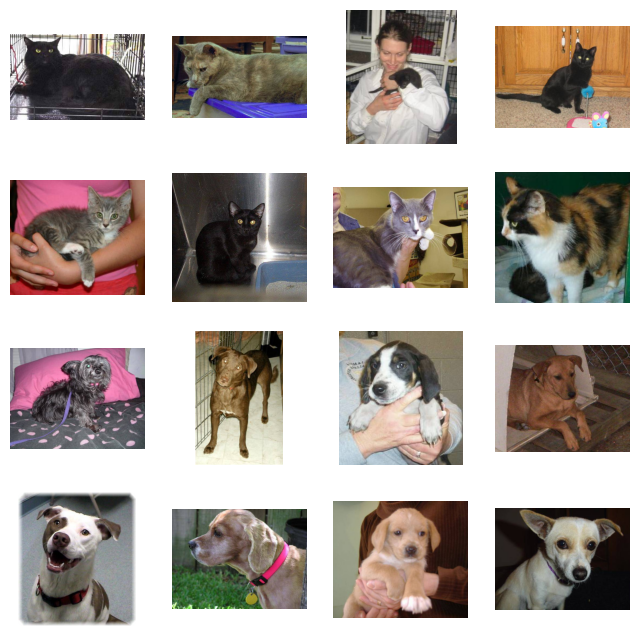

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# output images in a 4x4 configuration
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols * 2, nrows * 2)

paths_to_cat_images  = [os.path.join(train_cats_dir, fname)
                for fname in train_cat_fnames[0:8]]
paths_to_dog_images  = [os.path.join(train_dogs_dir, fname)
                for fname in train_dog_fnames[0:8]]

for i, img_path in enumerate(paths_to_cat_images + paths_to_dog_images):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off')

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Building a small convnet

The architecture of the neural network consists of 3 modules (convolution + relu + maxpooling), 2 fully-connected layers and sigmoid activation at the end of the network (because this is two-class classification problem), so that the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

Сonvolutions operate on 3x3 windows and maxpooling layers operate on 2x2 windows. The first convolution extracts 16 filters, the following one extracts 32 filters, and the last one extracts 64 filters.


In [7]:
from tensorflow.keras import layers
from tensorflow.keras import Model

In [8]:
# Input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

model = Model(img_input, output)

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496 

Model training with the binary crossentropy loss with RMSprop optimization, because it's a binary classification problem and final activation is a sigmoid.

In [10]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['acc'])

## Data preprocessing

Setting up data generators: Include data augmentation for the training images generator to prevent overfitting and improve the model's generalization. Additionally, set up a generator for the validation images without augmentation. The generators will produce batches of 20 images with dimensions 150x150 and their corresponding binary labels.



In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Training
Training on all 2000 images available, for 30 epochs, and validate on all 1000 validation images.
With data augmentation in place, the 2000 training images are randomly transformed each time a new training epoch runs, which means that the model will never see the same image twice during training.

In [12]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

Epoch 1/30
100/100 - 30s - loss: 0.7625 - acc: 0.5205 - val_loss: 0.6828 - val_acc: 0.5000 - 30s/epoch - 299ms/step
Epoch 2/30
100/100 - 15s - loss: 0.6917 - acc: 0.5475 - val_loss: 0.6648 - val_acc: 0.5980 - 15s/epoch - 145ms/step
Epoch 3/30
100/100 - 14s - loss: 0.6741 - acc: 0.5780 - val_loss: 0.6281 - val_acc: 0.6410 - 14s/epoch - 144ms/step
Epoch 4/30
100/100 - 15s - loss: 0.6565 - acc: 0.6110 - val_loss: 0.6062 - val_acc: 0.6610 - 15s/epoch - 145ms/step
Epoch 5/30
100/100 - 15s - loss: 0.6327 - acc: 0.6480 - val_loss: 0.5968 - val_acc: 0.6640 - 15s/epoch - 148ms/step
Epoch 6/30
100/100 - 16s - loss: 0.6299 - acc: 0.6435 - val_loss: 0.5964 - val_acc: 0.6790 - 16s/epoch - 156ms/step
Epoch 7/30
100/100 - 15s - loss: 0.6205 - acc: 0.6455 - val_loss: 0.6055 - val_acc: 0.6490 - 15s/epoch - 149ms/step
Epoch 8/30
100/100 - 15s - loss: 0.6217 - acc: 0.6475 - val_loss: 0.5629 - val_acc: 0.7070 - 15s/epoch - 150ms/step
Epoch 9/30
100/100 - 15s - loss: 0.6108 - acc: 0.6685 - val_loss: 0.5444

## Visualize the transformation of the input signal that passes through convnet

Picking a random cat or dog image from the training set and generating a: figure where each row is the output of a layer, each image in the row is a specific filter in that output feature map.

1/1 [==============================] - 0s 227ms/step


<ipython-input-13-338502b94693>:42: RuntimeWarning: invalid value encountered in divide
  x /= x.std()


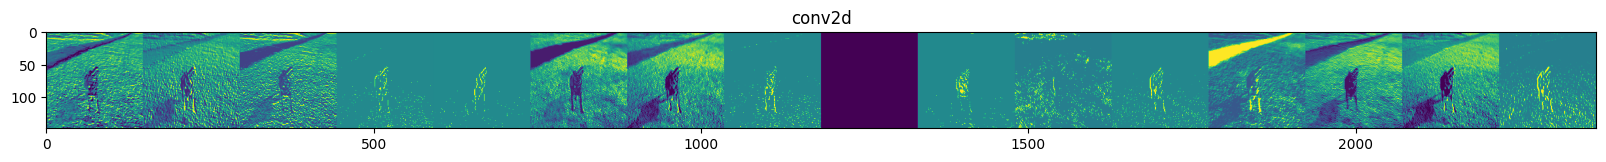

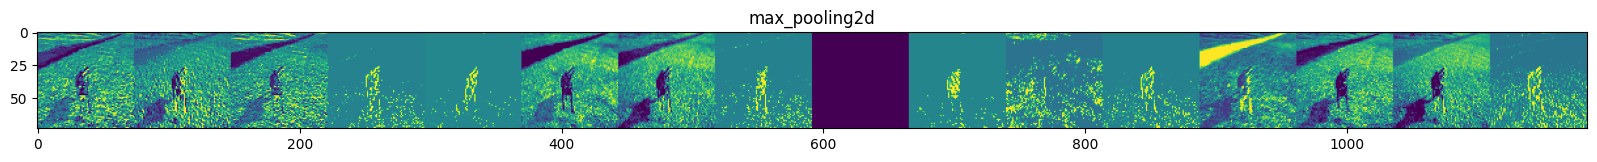

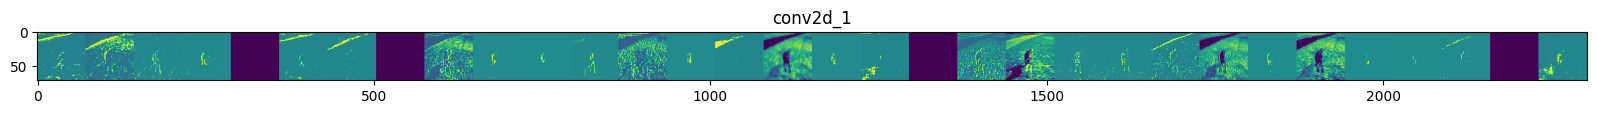

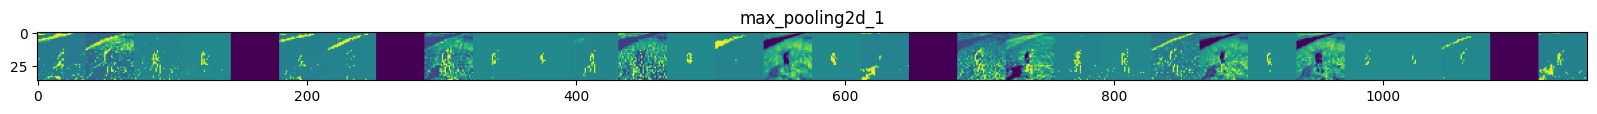

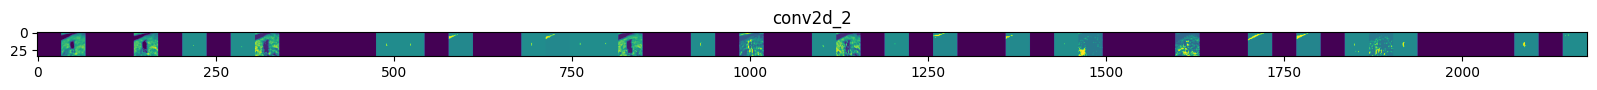

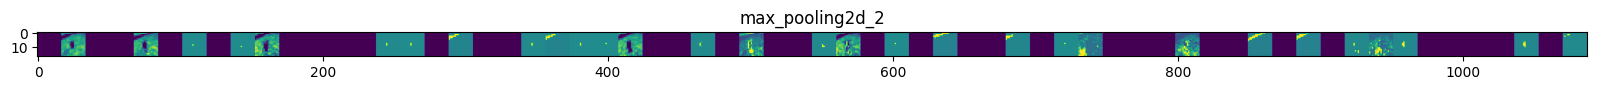

In [13]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(img_input, successive_outputs)

# Preparing a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)

img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Running image through network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of plot
layer_names = [layer.name for layer in model.layers[1:]]

# Displaying representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

The representations downstream start highlighting what the network pays attention to, and they show fewer and fewer features being "activated"; most are set to zero. This is called "sparsity."

These representations carry increasingly less information about the original pixels of the image, but increasingly refined information about the class of the image.

## Evaluating accuracy and loss for the model
Plotting the training/validation accuracy and loss as collected during training:

Text(0.5, 1.0, 'Training and validation loss')

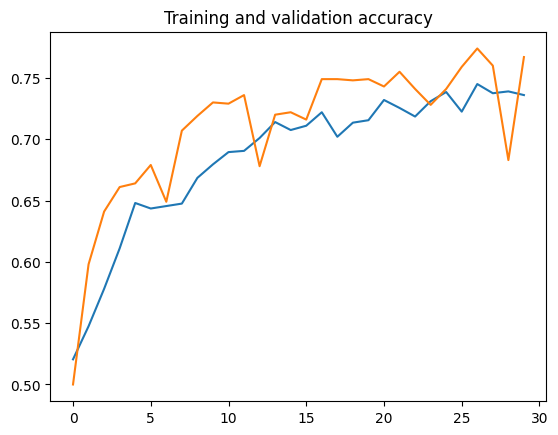

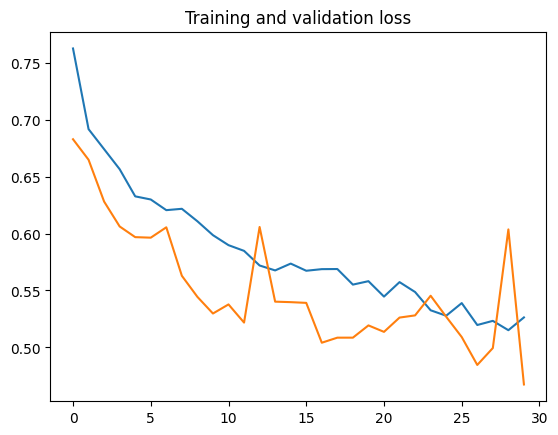

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

## Conclusion 1

Before adding Data Augmentation and Dropout, the model overfit on the data due to its limited quantity. The training accuracy (blue) approached 100%, while the validation accuracy (orange) plateaued at 70%. After the addition
the training and validation accuracies plateaued at 75%, there is no overfitting, but there is still room for improvement in the results.


## Feature extraction
Using mixed7 layer from the Inception V3 model, pre-trained on ImageNet, to keep a sufficiently large feature map (7x7 in this case).

In [15]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-10-02 09:47:31--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.136.207, 142.250.148.207, 209.85.200.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.136.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   190MB/s    in 0.4s    

2023-10-02 09:47:31 (190 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [16]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.0001),
              metrics=['acc'])

In [17]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=2,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/2


<ipython-input-17-223274cfaaff>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


100/100 - 22s - loss: 0.3503 - acc: 0.8575 - val_loss: 0.1335 - val_acc: 0.9490 - 22s/epoch - 216ms/step
Epoch 2/2
100/100 - 16s - loss: 0.2020 - acc: 0.9180 - val_loss: 0.0842 - val_acc: 0.9650 - 16s/epoch - 155ms/step


## Fine-Tuning

In [18]:
from tensorflow.keras.optimizers import SGD

unfreeze = False

for layer in pre_trained_model.layers:
  if unfreeze:
    layer.trainable = True
  if layer.name == 'mixed6':
    unfreeze = True

model.compile(loss='binary_crossentropy',
              optimizer=SGD(
                  learning_rate=0.00001,
                  momentum=0.9),
              metrics=['acc'])

In [19]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=35,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/35


<ipython-input-19-71216aae72bf>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


100/100 - 23s - loss: 0.2421 - acc: 0.9045 - val_loss: 0.1042 - val_acc: 0.9630 - 23s/epoch - 230ms/step
Epoch 2/35
100/100 - 16s - loss: 0.2321 - acc: 0.9100 - val_loss: 0.1207 - val_acc: 0.9540 - 16s/epoch - 162ms/step
Epoch 3/35
100/100 - 17s - loss: 0.2185 - acc: 0.9170 - val_loss: 0.1278 - val_acc: 0.9560 - 17s/epoch - 171ms/step
Epoch 4/35
100/100 - 17s - loss: 0.2365 - acc: 0.9050 - val_loss: 0.1292 - val_acc: 0.9570 - 17s/epoch - 167ms/step
Epoch 5/35
100/100 - 16s - loss: 0.2203 - acc: 0.9180 - val_loss: 0.1302 - val_acc: 0.9550 - 16s/epoch - 159ms/step
Epoch 6/35
100/100 - 16s - loss: 0.2302 - acc: 0.9135 - val_loss: 0.1294 - val_acc: 0.9530 - 16s/epoch - 160ms/step
Epoch 7/35
100/100 - 16s - loss: 0.2312 - acc: 0.9085 - val_loss: 0.1278 - val_acc: 0.9560 - 16s/epoch - 159ms/step
Epoch 8/35
100/100 - 16s - loss: 0.2148 - acc: 0.9235 - val_loss: 0.1275 - val_acc: 0.9550 - 16s/epoch - 159ms/step
Epoch 9/35
100/100 - 17s - loss: 0.2167 - acc: 0.9140 - val_loss: 0.1274 - val_acc:

Text(0.5, 1.0, 'Training and validation loss')

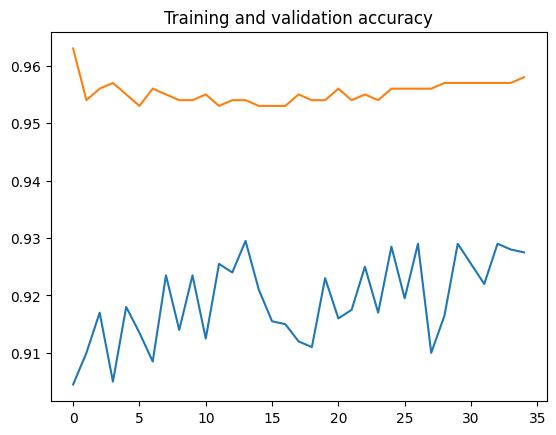

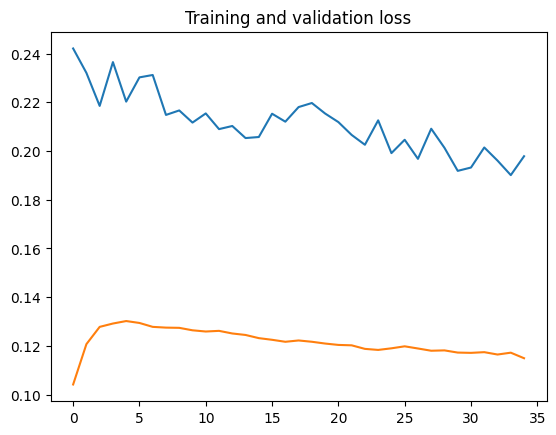

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

## Conclusion 2
After feature extraction using the pre-trained model and improving the accuracy by fine-tuning, the training and validation accuracies reached more than 90%, which is a significant improvement over previous results (~75%).
